In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import constants, signal
from scipy.signal import hilbert, chirp
from scipy.fft import fft, fftfreq, fftshift

from pathlib import Path

In [6]:
def csv(filename: str, skiprows = 4):
    """Reads a csv file at a particular location, and extracts the sampling frequency by assuming the first column read in csv file is the time axis, in seconds

    Args:
        filename (std): the path to the file we want to analyze 
        skiprows (int, optional): the number of rows in the data file we want to skip. Defaults to 4.

    Returns:
        A pandas data frame containing the data, and the sampling frequency  
    """
    df = pd.read_csv(filename, delimiter=",", skiprows = skiprows, header=None)
    t = df.iloc[:,0].to_numpy()
    
    # compute fs by taking the average slope of the time axis 
    fs = np.round(1/np.mean(np.gradient(t)))
    print("Rounded to sampling frequency: {} Hz".format(fs))
    print("Actual: {} Hz".format(1/(t[1] - t[0])))
    return df, fs 

Let's start by understanding what comes out a power spectral density calculation. To do that, we'll synthesize a signal with some noise

In [7]:
# fs = sampling frequency
fs = 50e3
N = int(500000) # N = Number of samples
amp = 2*np.sqrt(2) # Amplitude of our sine wave, 2 Vrms
freq = 1234.0 # frequency the sine wave

# define the noise power here 
noise_power = 0.001 * fs / 2 
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

By calling [`signal.welch`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html), we can calculate the signal power spectral density Welch's method. We will do this in two different ways, using a hanning window with a small number of points (1024), and a large number of points (equal to the entire length of the signal). 
- Windowing helps us to better estimate the frequency composition of a signal when we do a numerical fourier transforms
- Choosing a correct window is a complex topic! But most of the time, a hanning window works. It balances between having good frequency resolution (little spectral leakage, i.e. ability to resolve closely spaced peaks), and amplitude resolution
- For more information on the different windows available in python: `https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html#scipy.signal.get_window`

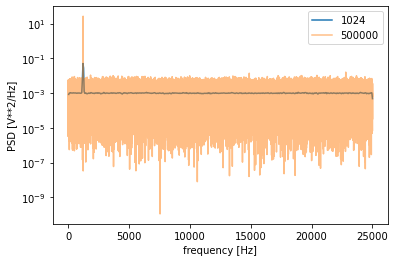

In [13]:
f, Pxx_den = signal.welch(x, fs, window=signal.windows.hann(1024,))
plt.semilogy(f[f>=1], Pxx_den[f>=1], label = "1024")

f, Pxx_den = signal.welch(x, fs, window=signal.windows.hann(int(N),))

plt.semilogy(f[f>=1], Pxx_den[f>=1], alpha = 0.5, label = int(N))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()

We see that using a smaller window length (1024 points), gives a better estimate of the signal noise floor. In fact, if we average over the protion of where the power spectral density appears flat (the noise floor, we can recover the noise power in our signal!

In [16]:
f, Pxx_den = signal.welch(x, fs, window=signal.windows.hann(1024,))
print(np.mean(Pxx_den[256:]))

0.000997665031578638


### Extracting noise floor 
Now lets apply this to some real data, and extract the noise floor from a measurement. 

In [21]:
dir = Path("../data")
dat = dict() 

for d in dir.glob("*.csv"):
    dat_num = int(d.stem.replace("dat", ""))
    dat[dat_num] = d 
    
# heres a list of all the data we have 
dat

{1: WindowsPath('../data/dat1.csv')}

In [29]:
# lets read the data
df, fs = csv(dat[1])
t = df.iloc[:,0].to_numpy()
y = df.iloc[:,1].to_numpy()

Rounded to sampling frequency: 500000.0 Hz
Actual: 499999.9999856222 Hz


Text(0, 0.5, 'Voltage (V)')

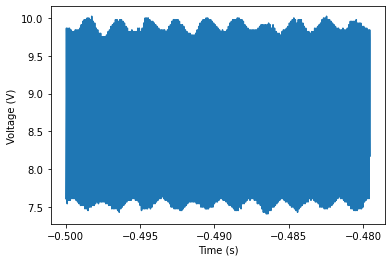

In [31]:
# We can plot a small segment of the data, 10*1024 points
plt.plot(t[:10*1024], y[:10*1024])
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

To estimate the noise floor, let's use a spectrum computed using 10*1024 points (corresponding to ~ 10 modulation cycles in the data). To estimate the peak, we use the full length of the signal

(100, 250000.0)

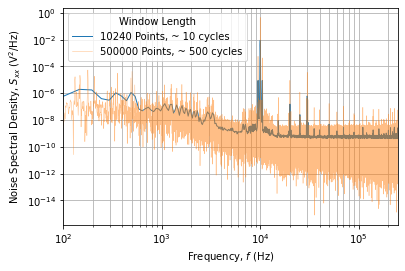

In [33]:
fig, ax = plt.subplots() 
f, Pxx_den = signal.welch(y, fs = fs, window=signal.windows.hann(10*1024,))
ax.loglog(f, Pxx_den, lw = 1, label = "10240 Points, ~ 10 cycles")

f, Pxx_den = signal.welch(y, fs = fs, window=signal.windows.hann(len(y)))

ax.loglog(f, Pxx_den, alpha = 0.5, lw = 0.5, label = "500000 Points, ~ 500 cycles")
    
ax.legend(title = "Window Length")
ax.grid(which="both")
ax.set_xlabel("Frequency, $\mathit{f}$ (Hz)")
ax.set_ylabel("Noise Spectral Density, $\mathit{S}_{xx}$ (V$^{2}$/Hz)")
ax.set_xlim(100, 250e3)

From the plot above, we can directly read out a signal to noise ratio of approximately $10^{8}$, by comparing the peak height of the orange trace (~ $10^{0}$), to the level at the noise floor $(10^{-9})$.

We see that the blue power spectrum reaches the noise floor at around $2 \times 10^{4}$ Hz. We can estimate the noise floor by averaging the spectrum over all points greater than or equal to $2 \times 10^{4}$ Hz. To get it into units of $V^{2}/\sqrt{Hz}$ as often used in noise floor specifications, we take the square root of the average. 

In [43]:
f, Pxx_den = signal.welch(y, fs = fs, window=signal.windows.hann(10*1024,))
# average all samples for which the frequency is greater than 20 kHz
nf = np.mean(Pxx_den[f>=2e4])

# convert the noise floor
np.sqrt(nf)

2.963118171069497e-05